In [58]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [59]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the athlete lands in an "L" shape, perpendicular to the bar
def is_l_shaped_landing(hip, knee, ankle):
    """
    Determines if the athlete lands in an "L" shape by analyzing the angles
    formed by the hip, knee, and ankle. The condition is met when the knee
    forms an approximately 90-degree angle with the hip and ankle.
    """
    hip_x, hip_y = hip
    knee_x, knee_y = knee
    ankle_x, ankle_y = ankle

    # Calculate the angle between hip, knee, and ankle
    upper_leg = np.array([hip_x - knee_x, hip_y - knee_y])
    lower_leg = np.array([ankle_x - knee_x, ankle_y - knee_y])

    # Compute the cosine of the angle using dot product
    cosine_angle = np.dot(upper_leg, lower_leg) / (np.linalg.norm(upper_leg) * np.linalg.norm(lower_leg) + 1e-5)
    angle = np.arccos(cosine_angle) * (180 / np.pi)

    # Landing is considered in "L" shape if the angle is around 90 degrees
    return 80 <= angle <= 100

# Paths for the stage 5 videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage5/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage5/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints for landing analysis
                left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
                left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
                left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]

                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
                right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]
                right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y]

                # Check if the athlete landed in an "L" shape for both sides
                left_landing = is_l_shaped_landing(left_hip, left_knee, left_ankle)
                right_landing = is_l_shaped_landing(right_hip, right_knee, right_ankle)

                # Store data for this frame
                # Store data for this frame with standard Python booleans and float conversion
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "left_landing": bool(left_landing),  # Convert to Python boolean
                    "right_landing": bool(right_landing),  # Convert to Python boolean
                    "left_hip": [float(coord) for coord in left_hip],  # Convert coordinates to float
                    "left_knee": [float(coord) for coord in left_knee],
                    "left_ankle": [float(coord) for coord in left_ankle],
                    "right_hip": [float(coord) for coord in right_hip],
                    "right_knee": [float(coord) for coord in right_knee],
                    "right_ankle": [float(coord) for coord in right_ankle]
                })

        # Release the video
        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("L-shape landing analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737667072.500774 11215657 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737667072.559310 11433456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737667072.570794 11433457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


L-shape landing analysis complete! JSON files saved in 'keypoints' folder.


In [60]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for "L" shape landing analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage5/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract landing indicators across all frames
        landing_data = [
            [int(frame["left_landing"]), int(frame["right_landing"])]
            for frame in data
        ]
        sequences.append(landing_data)

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

        labels.append(label)

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 14 sequences with labels.


In [61]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 70


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Ensure correct shape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 2))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 53, Validation samples: 17


In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print(model.summary())


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [64]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs= 1000,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.6018 - mae: 0.6513 - val_loss: 0.2269 - val_mae: 0.3787
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3984 - mae: 0.5636 - val_loss: 0.3397 - val_mae: 0.5420
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2204 - mae: 0.3986 - val_loss: 0.3738 - val_mae: 0.5663
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1748 - mae: 0.3594 - val_loss: 0.3652 - val_mae: 0.5464
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1979 - mae: 0.4009 - val_loss: 0.3895 - val_mae: 0.5601
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2087 - mae: 0.4087 - val_loss: 0.4519 - val_mae: 0.5859
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1775 - mae: 0.3234 - val_loss: 0.4134 - val_mae: 0.5693
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1790 - mae: 0.3675 - val_loss: 0.3445 - val_mae: 0.5377
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.15

In [65]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.3516, Validation MAE: 0.4968


In [66]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Predicted: 0.01, Actual: 1.00
Predicted: 0.70, Actual: 0.00
Predicted: 0.70, Actual: 0.00
Predicted: 0.70, Actual: 0.00
Predicted: 0.70, Actual: 1.00
Predicted: 0.92, Actual: 1.00
Predicted: 0.70, Actual: 0.00
Predicted: 0.02, Actual: 0.00
Predicted: 0.70, Actual: 0.00
Predicted: 1.04, Actual: 0.00
Predicted: 0.70, Actual: 0.00
Predicted: 0.70, Actual: 1.00
Predicted: 0.94, Actual: 1.00
Predicted: 0.70, Actual: 1.00
Predicted: 0.95, Actual: 0.50
Predicted: 0.70, Actual: 0.00
Predicted: 0.00, Actual: 0.00


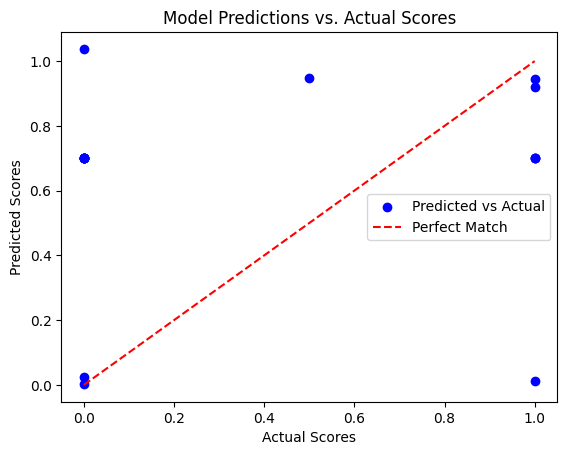

In [67]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [68]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the athlete lands in an "L" shape position
def is_l_shape_landing(hip, knee, ankle):
    """
    Determines if the athlete lands in an 'L' shape position by analyzing the 
    alignment of the hip, knee, and ankle.
    Conditions:
    - The hip should be positioned vertically above the knee.
    - The knee should be at a right angle with the ankle.
    """
    hip_x, hip_y = hip
    knee_x, knee_y = knee
    ankle_x, ankle_y = ankle

    # Condition for 'L' shape landing: hip over knee, knee bent at ~90 degrees
    hip_above_knee = abs(hip_x - knee_x) < 0.05 and hip_y < knee_y
    knee_bent = abs(knee_y - ankle_y) > 0.1 and abs(knee_x - ankle_x) < 0.05

    return hip_above_knee and knee_bent

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage5/test_videos/1_user5.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for 'L' shape landing analysis
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]

        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y]

        # Check for 'L' shape landing on both sides
        left_landing = is_l_shape_landing(left_hip, left_knee, left_ankle)
        right_landing = is_l_shape_landing(right_hip, right_knee, right_ankle)

        # Store the binary values (0 or 1) for analysis
        new_keypoints.append([int(left_landing), int(right_landing)])

cap.release()

# Pad the sequence to match training input length
max_seq_length = X_train.shape[1]  # Ensure it's the same length used during training
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Reshape to match model input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((new_keypoints_padded.shape[0], new_keypoints_padded.shape[1], 2))

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737667383.896980 11215657 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737667383.959540 11547403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737667383.970034 11547403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Predicted Score: 0.70


In [69]:
print(X_train.shape[1])

51


In [77]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.65:
        return 1.0
    elif prediction >= 0.4:
        return 0.5
    else:
        return 0.0

In [78]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Classified: 0.0, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 0.5
Classified: 1.0, Actual: 0.0
Classified: 0.0, Actual: 0.0


In [79]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [80]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [81]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Classification Accuracy: 0.41


In [82]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage5/models/highjump_stage5.keras")